In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# chage path as you want
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
from copy import deepcopy
from IPython.display import display, HTML
import math
from math import sin, cos
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np
from numpy.random import rand
import pickle
import time
from tqdm import tqdm

PI = math.pi

class ThrowingEnvironmentBase():
    def __init__(self, student_id, q_size):

        # Kinematic / Dynamic parameters
        self.bound = [(-PI/2, PI/2), (-PI/2, PI/2), (-3*PI, 3*PI), (-3*PI, 3*PI)] # lower/upper bounds for theta1, theta2, omega1, omega2
        self.length = [1.0, 1.0] # L1, L2
        self.gravity = 9.8
        self.trashcan_position = [6.0, -4.0]
        self.trashcan_height = 2.0
        self.trashcan_radius = 3
        self.robot_mass = [1.0, 1.0]
        self.trash_mass =  0.5
        self.trash_color = 'lightgray'
        self.torque = 10.0
        self.dt = 0.01
        self.action_list = [[1,1,0],[1,-1,0],[-1,1,0],[-1,-1,0],[1,1,1],[1,-1,1],[-1,1,1],[-1,-1,1]]
                            # upper arm, lower arm, holding trash = 0 / released = 1

        # Reinforcement Learning parameters
        self.alpha = 0.1
        self.gamma = 0.99
        self.epsilon = 0.1

        self.fail_reward = -100.0
        self.success_reward = 1000.0
        self.reward_per_step = 0

        self.state = [0.0, 0.0, 0.0, 0.0] # theta1, theta2, omega1, omega2
        self.trash_state = [0.0, -2.0, 0.0, 0.0] # x, y, vx, vy
        self.is_released = 0 # 1 : released
        self.terminal = 0 # 1 : terminate

        # Class information
        self.epoch = 0
        self.step = 0
        self.step_limit = 500
        self.step_per_epoch = []
        self.q_max_per_epoch = []
        self.q_avg_per_epoch = []
        self.success_number = 0

        # Input information
        self.q_size = q_size
        self.q_table = np.zeros(q_size + [8])
        self.student_id = student_id
        self.seed = int(student_id.split('-')[1])
        np.random.seed(self.seed)
        print("Environment Initialized")

    def state_mod(self): # function to make thetas in the range of (-PI, PI)
        for i in range(2):
            n = int(self.state[i] / (2 * PI))
            self.state[i] -= n * (2 * PI)
            if self.state[i] > PI:
                self.state[i] -= 2 * PI
            if self.state[i] < - PI:
                self.state[i] += 2 * PI
            if self.state[i] > PI:
                self.state[i] -= 2 * PI
            if self.state[i] < - PI:
                self.state[i] += 2 * PI

    def end_position(self): # end-effector position
        t = self.state[0:2]
        l = self.length
        return [sin(t[0])*l[0]+sin(t[0] + t[1])*l[1], -cos(t[0])*l[0]-cos(t[0] + t[1])*l[1]]

    def end_velocity(self): # end-effector velocity
        t = self.state[0:2]
        w = self.state[2:4]
        l = self.length
        return [l[0]*cos(t[0])*w[0]+l[1]*cos(t[0]+t[1])*(w[0]+w[1]), l[0]*sin(t[0])*w[0]+l[1]*sin(t[0]+t[1])*(w[0]+w[1])]

    def reset(self, fixed_state = None): # restart simulation / training
        self.state = [(rand()-0.5)*(self.bound[0][1]-self.bound[0][0])/3, (rand()-0.5)*(self.bound[1][1]-self.bound[1][0])/3, 0, 0]
        if fixed_state is not None:
            self.state = fixed_state
        self.trash_state = deepcopy(self.end_position()+self.end_velocity())
        self.is_released = 0
        self.terminal = 0
        self.step = 0
        self.trash_color = 'lightgray'

    def action_sample_idx(self): # sample random action index
        pass

    def epsilon_greedy_action_idx(self, state_idx): # epsilon greedy action, TODO
        pass

    def discretize(self, state): # make continuous state to discrete state, and return its index
        idx = np.zeros_like(state, dtype=int)
        for i in range(len(state)):
            idx[i] = min(max(math.floor((state[i]-self.bound[i][0]) / (self.bound[i][1]-self.bound[i][0]) * self.q_size[i]),0), self.q_size[i]-1)
        return tuple(idx)

    def derivs(self, action): # dynamics of robot arm and trash
        dydx = np.zeros_like(self.state)
        M1, M2 = self.robot_mass[0], self.robot_mass[1]
        M = self.trash_mass
        if self.is_released:
            M = 0
        L1, L2 = self.length
        G = self.gravity
        theta1, theta2 = self.state[0], self.state[0] + self.state[1]
        omega1, omega2 = self.state[2], self.state[2] + self.state[3]
        dydx[0] = omega1
        dydx[1] = omega2
        delta = theta2 - theta1
        den1 = (M+M1+M2) * L1 - (M+M2) * L1 * cos(delta) * cos(delta)
        dydx[2] = (((M+M2) * L1 * omega1 * omega1 * sin(delta) * cos(delta)
                    + (M+M2) * G * sin(theta2) * cos(delta)
                    + (M+M2) * L2 * omega2 * omega2 * sin(delta)
                    - (M+M1+M2) * G * sin(theta1))
                / den1)
        den2 = (L2/L1) * den1
        dydx[3] = ((- (M+M2) * L2 * omega2 * omega2 * sin(delta) * cos(delta)
                    + (M+M1+M2) * G * sin(theta1) * cos(delta)
                    - (M+M1+M2) * L1 * omega1 * omega1 * sin(delta)
                    - (M+M1+M2) * G * sin(theta2))
                / den2)
        dydx[1] -= dydx[0]
        dydx[3] -= dydx[2]
        dydx[2] += self.torque * action[0]
        dydx[3] += self.torque * action[1]
        return dydx

    def next_state(self, action): # find (next_state, instant reward, whether the trash has been released or not, whether the simulation should be terminated or not) using current state and input action
        assert len(action)==3, "action space dim should be 3"
        new_state = self.state + self.derivs(action) * self.dt
        self.state = new_state
        self.state_mod()
        if not self.is_released:
            self.trash_state = deepcopy(self.end_position()+self.end_velocity())
        self.is_released = self.is_released + action[2]
        token = 0
        for i in range(len(self.state)):
            if self.state[i]<self.bound[i][0] or self.state[i]>self.bound[i][1]:
                token = i
                break
        if token or self.is_released or self.step > self.step_limit:
            self.terminal = 1
        return self.state, deepcopy(self.reward()), self.is_released, self.terminal

    def reward(self): # reward for current state and action
        if not self.is_released:
            if self.terminal:
                return self.fail_reward
            return self.reward_per_step

        trashcan_upperleft = [self.trashcan_position[0]-self.trashcan_radius, self.trashcan_position[1]+self.trashcan_height]
        trashcan_upperright = [self.trashcan_position[0]+self.trashcan_radius, self.trashcan_position[1]+self.trashcan_height]
        trash_position = self.trash_state[0:2]
        trash_velocity = self.trash_state[2:4]
        if trash_velocity[0] <= 0:
            return self.fail_reward
        time_l = (trashcan_upperleft[0] - trash_position[0]) / trash_velocity[0]
        trash_left = trash_position[1] + trash_velocity[1] * time_l - 1/2 * self.gravity * time_l ** 2
        if trash_left < trashcan_upperleft[1]:
            return self.fail_reward
        time_r = (trashcan_upperright[0] - trash_position[0]) / trash_velocity[0]
        trash_right = trash_position[1] + trash_velocity[1] * time_r - 1/2 * self.gravity * time_r ** 2
        if trash_right > trashcan_upperright[1]:
            return self.fail_reward
        time_inside = (trash_velocity[1] + math.sqrt(trash_velocity[1]**2 - 2 * self.gravity * (trashcan_upperleft[1]-trash_position[1]))) / self.gravity
        reward_inside = self.success_reward * (2 - abs(time_inside * trash_velocity[0] + trash_position[0] - self.trashcan_position[0]) / self.trashcan_radius)
        return reward_inside

    def train_step(self): # train one step, TODO
        pass

    def train(self, train_n): # training
        for _ in tqdm(range(train_n)):
            self.reset()
            self.epoch += 1
            while not self.is_released:
                terminal = self.train_step()
                if terminal:
                    break
            self.step_per_epoch.append(self.step)
            self.q_max_per_epoch.append(np.max(self.q_table))
            self.q_avg_per_epoch.append(np.average(self.q_table))
            if self.reward()>0:
                self.success_number += 1

    def visualization_step(self): # visualize one step
        self.step += 1
        state_idx = self.discretize(self.state)
        A = self.q_table[state_idx]
        action = self.action_list[np.random.choice(np.where(A == A.max())[0])]
        if not self.is_released:
            _, _, _, _ = self.next_state(action)

        return self.terminal, deepcopy(self.reward())

    def visualization(self): # visualize, when released or terminated - the robot stops; when released - the trash moves in projectile motion
        if (not self.is_released) and (self.terminal):
            return self.terminal, deepcopy(self.reward())

        terminal, reward, = self.visualization_step()
        if self.is_released:
            if ((self.trash_state[0] >= (self.trashcan_position[0] - self.trashcan_radius)) and ((self.trashcan_position[0] + self.trashcan_radius) >=self.trash_state[0]) and \
                (self.trash_state[1]>=self.trashcan_position[1]) and ((self.trashcan_position[1] + self.trashcan_height) >= self.trash_state[1])):
                previous_velocity_x = self.trash_state[2]
                previous_velocity_y = self.trash_state[3] + self.gravity * self.dt
                previous_position_x = self.trash_state[0] - previous_velocity_x * self.dt
                previous_position_y = self.trash_state[1] - previous_velocity_y * self.dt + 1/2 * self.gravity * self.dt **2
                left_height = (previous_position_y - self.trash_state[1]) / (previous_position_x - self.trash_state[0]) * \
                                (self.trashcan_position[0] - self.trashcan_radius - self.trash_state[0]) + self.trash_state[1]
                if left_height < self.trashcan_position[1] + self.trashcan_height:
                    self.trash_state[2] = - self.trash_state[2]
                else:
                    self.trash_color = 'green'

            if (self.trash_color == 'lightgray'):
                self.trash_state[0] += self.dt * self.trash_state[2]
                self.trash_state[1] += self.dt * self.trash_state[3] - 1/2 * self.gravity * self.dt ** 2
                self.trash_state[3] += - self.gravity * self.dt

        return terminal, reward

    def summary(self): # training information
        fig = plt.figure(figsize=(10,12))
        ax1 = fig.add_subplot(311)
        ax1.plot(self.step_per_epoch)
        ax1.set_title("step per epoch")
        ax2 = fig.add_subplot(312)
        ax2.plot(self.q_max_per_epoch)
        ax2.set_title("Q_max per epoch")
        ax3 = fig.add_subplot(313)
        ax3.plot(self.q_avg_per_epoch)
        ax3.set_title("Q_avg per epoch")
        print("success rate : ",str(self.success_number),"/",str(self.epoch))

    def plot_state(self): # plot current state
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.axis('equal')
        ax.axis([-3, 11, -5, 5])

        x = [0, sin(self.state[0])*self.length[0], sin(self.state[0])*self.length[0]+sin(self.state[0] + self.state[1])*self.length[1]]
        y = [0, -cos(self.state[0])*self.length[0], -cos(self.state[0])*self.length[0]-cos(self.state[0] + self.state[1])*self.length[1]]
        ax.plot(x, y, color = 'b', linewidth = 5)
        ax.add_patch(plt.Circle((self.trash_state[0],self.trash_state[1]),0.2,edgecolor = 'deeppink', facecolor = 'lightgray', fill = True))
        trashcan_x = [self.trashcan_position[0]-self.trashcan_radius, self.trashcan_position[0]-self.trashcan_radius,
                        self.trashcan_position[0]+self.trashcan_radius, self.trashcan_position[0]+self.trashcan_radius]
        trashcan_y = [self.trashcan_position[1]+self.trashcan_height, self.trashcan_position[1],
                        self.trashcan_position[1], self.trashcan_position[1]+self.trashcan_height]
        ax.plot(trashcan_x, trashcan_y, color = 'r', linewidth = 5)
        ax.text(0.05, 0.9, 'Current State', transform = ax.transAxes)

        plt.show()

    def plot_simulate(self, duration, reset = True, is_display = True, save_mp4 = True, save_name = 'simulation'): 
        if reset:
            self.reset()
        saved_state = self.state

        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(autoscale_on=False, xlim=(-3, 11), ylim=(-5, 5))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_aspect('equal')

        def animate(i):
            plt.cla()
            terminal, reward = self.visualization()
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.axis('equal')
            ax.axis([-3, 11, -5, 5])
            # print(self.state)
            x = [0, sin(self.state[0])*self.length[0], sin(self.state[0])*self.length[0]+sin(self.state[0] + self.state[1])*self.length[1]]
            y = [0, -cos(self.state[0])*self.length[0], -cos(self.state[0])*self.length[0]-cos(self.state[0] + self.state[1])*self.length[1]]
            ax.plot(x, y, color = 'b', linewidth = 5)
            ax.add_patch(plt.Circle((self.trash_state[0],self.trash_state[1]),0.2,edgecolor = 'green', facecolor = self.trash_color, fill = True))
            trashcan_x = [self.trashcan_position[0]-self.trashcan_radius, self.trashcan_position[0]-self.trashcan_radius,
                          self.trashcan_position[0]+self.trashcan_radius, self.trashcan_position[0]+self.trashcan_radius]
            trashcan_y = [self.trashcan_position[1]+self.trashcan_height, self.trashcan_position[1],
                          self.trashcan_position[1], self.trashcan_position[1]+self.trashcan_height]
            ax.plot(trashcan_x, trashcan_y, color = 'r', linewidth = 5)
            if self.is_released:
                ax.text(0.05, 0.9, 'time = %.1fs, released'%(i*self.dt),transform = ax.transAxes)
            elif terminal:
                ax.text(0.05, 0.9, 'time = %.1fs, terminated'%(i*self.dt),transform = ax.transAxes)
            else:
                ax.text(0.05, 0.9, 'time = %.1fs'%(i*self.dt),transform = ax.transAxes)
            if reward > 0:
                ax.text(0.05, 0.05, 'success', transform = ax.transAxes)

            return fig,

        if is_display:
            self.reset()
            self.state = saved_state
            ani = animation.FuncAnimation(fig, animate, repeat_delay = 500,
                                        frames=int(duration/self.dt), interval=self.dt * 1000, blit=True)
            display(HTML(ani.to_jshtml()))

        if save_mp4:
            self.reset()
            self.state = saved_state
            ani2 = animation.FuncAnimation(fig, animate, repeat_delay = 500,
                                            frames=int(duration/self.dt), interval=self.dt * 1000, blit=True)
            ani2.save('RL_'+save_name+'.mp4')

    def load_model(self, filename): # load your model using .pkl
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            self.q_table = data[0]
            self.step_per_epoch = data[1]
            self.q_max_per_epoch = data[2]
            self.q_avg_per_epoch = data[3]
            self.success_number = data[4]
            self.epoch = data[5]
            self.student_id = data[6]

    def save_model(self, filename): # save your model using .pkl
        Q_TABLE = self.q_table
        STEP_PER_EPOCH = self.step_per_epoch
        Q_MAX_PER_EPOCH = self.q_max_per_epoch
        Q_AVG_PER_EPOCH = self.q_avg_per_epoch
        SUCCESS_NUMBER = self.success_number
        EPOCH = self.epoch
        STUDENT_ID = self.student_id
        OBJECTS = [Q_TABLE, STEP_PER_EPOCH, Q_MAX_PER_EPOCH, Q_AVG_PER_EPOCH, SUCCESS_NUMBER, EPOCH, STUDENT_ID]
        with open(filename, 'wb') as f:
            pickle.dump(OBJECTS, f, pickle.HIGHEST_PROTOCOL)

    def submit(self): # create your submit file
        filename = self.student_id + '.pkl'
        self.save_model(filename)

Environment Initialized


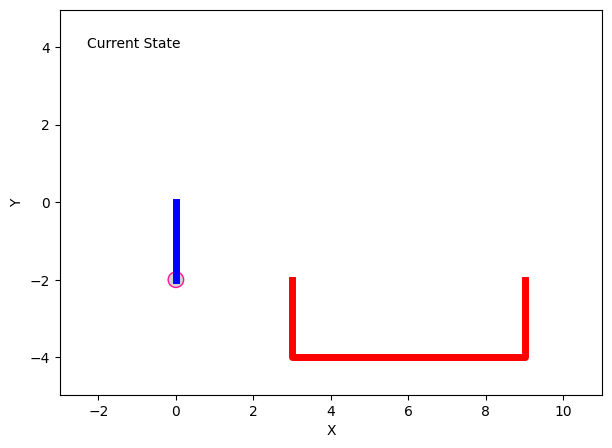

In [4]:
class ThrowingEnvironment(ThrowingEnvironmentBase):
    def __init__(self, student_id="0000-00000", q_size=[10, 10, 10, 10]):
        super().__init__(student_id=student_id, q_size=q_size)

        # Reinforcement Learning parameters
        self.alpha = 0.1
        self.gamma = 0.99
        self.epsilon = 0.1

    def action_sample_idx(self):
        # sample random action index
        action_idx = np.random.randint(len(self.action_list))
        return action_idx

    def epsilon_greedy_action_idx(self, state_idx):
       
        if np.random.rand() < self.epsilon:
            action_idx = self.action_sample_idx()  # sample random action index
        else:
            # Choose the action with the highest Q-value for the current state
            action_idx = np.argmax(self.q_table[state_idx])

        return action_idx

    def train_step(self):
        
        self.step += 1
        state_idx = self.discretize(self.state)
        action_idx = self.epsilon_greedy_action_idx(state_idx)
        action = self.action_list[action_idx]
        next_state, reward, _, terminal = self.next_state(action)
        next_state_idx = self.discretize(next_state)
        if action[2] == 1:  # When the trash is released
            self.q_table[state_idx][action_idx] = reward
        else:
            # Update Q-value using the Q-learning update rule
            self.q_table[state_idx][action_idx] += self.alpha * (
                reward + self.gamma * np.max(self.q_table[next_state_idx]) - self.q_table[state_idx][action_idx]
            )
        return terminal

discretize = [10, 10, 10, 10]
MODEL = ThrowingEnvironment(student_id, q_size=discretize)
MODEL.plot_state()

#Now, let's train the model.

In [5]:
# train the model
train_steps = 1000000
MODEL.train(train_steps)
time.sleep(0.2)

# save the model
MODEL.submit()

100%|██████████| 1000000/1000000 [39:31<00:00, 421.63it/s]


#Let's check if the model has been trained well.

In [ ]:
# test your trained model
MODEL.reset([-PI/12, PI/6, 0, 0])
MODEL.plot_simulate(5, reset = False, is_display=True, save_mp4=True, save_name='simulation')